# SEG 2016 Facies Competition


In 2016 Matt @ Agile & Brendon @ Enthought setup a Machine Learning Contest with the SEG. 

The objective was to predict facies logs from a small set of well log data. The image below (source: www.agilescientific.com) shows the wirelines and facies targets for one well

![](agile_blog_seg_facies_image.png)

Two wells were held out as blind and used to create the final scores.

![](leaderboard.png)

In this notebook, we've taken the winning submission from `LA_Team` Lukas Mosser & Alfredo de la Fuente.

This Was Gradient Boosted Trees selected and tuned by TPOT.

here we are going to tune that model with Raytune instead


# Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


We have already applied the preprocessing steps from the contest entry notebook and saved these to `h5py` so we can load these here

In [3]:
import h5py


# define a loading function
def setup(filepath):
    with h5py.File(filepath, 'r') as f:
        X_train = f["train_x"][:]
        y_train = f["train_y"][:]
        group_train = f["train_groups"][:]
        train_wells = f["train_groups"].attrs["well_names"]        
        
        X_test = f["test_x"][:]
        y_test = None
#         y_test = f["test_y"]
        group_test = f["test_groups"][:]
        test_wells = f["test_groups"].attrs["well_names"]

    return X_train, y_train, group_train, X_test, y_test, group_test, (train_wells, test_wells)

The tuned model parameters
```
XGBClassifier(learning_rate=0.12,
              max_depth=3,
              min_child_weight=10,
              n_estimators=150,
              seed=seed,
              colsample_bytree=0.9)
```

Let's check the data is on the expected path

In [4]:
from os import path
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')
print(filepath)

/home/steve/dev/transform-2020-ray/datasets/seg_2016_facies/la_team_5_data.h5py


## Tuning function

Again we define an end to end tuning function

In [5]:
from sklearn.model_selection import LeavePGroupsOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy.signal import medfilt
from filelock import FileLock

def e2e_train_and_test(config, **kwargs):
    
    # load the data
    X, y, groups, X_test, y_test, group_test, well_names = setup(kwargs['filepath'])
    
    #
    # chose your CV strategy. groups == wells
    #
    splitter = LeavePGroupsOut(1)
    
    #
    # run k fold training and validation
    #
    f1_scores = [] # keep hold of all individual scores
    for train_ind, val_ind in splitter.split(X, y, groups=groups):
        pipeline = make_pipeline(RobustScaler(),
                                  XGBClassifier())

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[val_ind])
        
        f1_scores.append(f1_score(y_pred, y[val_ind], average='micro'))
    
        # Clean isolated facies for each well
        y_pred = medfilt(y_pred, kernel_size=5)
    
    #
    # use tune's reporter
    #
    tune.track.log(
                mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

The following config is locked to the winning parameters

In [6]:
tuning_config = {
    'xgbclassifier__learning_rate': 0.12,
    'xgbclassifier__max_depth': 3,
    'xbgclassifier__min_child_weight' :10,
    'xbgclassifier__n_estimators': 150,
    'xgbclassifier__seed':1773,
    'xgbclassifier__colsample_bytree':0.9
}

Let's update that to use distributions

In [7]:
ray_tuning_config = {
    'xgbclassifier__learning_rate': tune.loguniform(0.001, 0.5),
    'xgbclassifier__max_depth': tune.randint(1, 10),
    'xgbclassifier__min_child_weight': tune.loguniform(0.1,100),
    'xgbclassifier__n_estimators': tune.randint(5,200),
    'xgbclassifier__colsample_bytree': tune.choice([0.4, 0.6, 0.8, 1.0]),
    'xgbclassifier__lambda': tune.choice([0,1]),
    'xgbclassifier__seed': 42
}

In [9]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=0, include_webui=True)

2020-06-12 10:51:47,328	INFO resource_spec.py:204 -- Starting Ray with 33.06 GiB memory available for workers and up to 16.55 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-12 10:51:47,590	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:17851',
 'object_store_address': '/tmp/ray/session_2020-06-12_10-51-47_326678_132346/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-12_10-51-47_326678_132346/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-12_10-51-47_326678_132346'}

In [12]:
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')

# wrap our end to end function to inject our filepath
def e2e_seg(config):
    return e2e_train_and_test(config, filepath=filepath)

analysis = tune.run(
                e2e_seg,
                config=ray_tuning_config,
    
                num_samples=15, # Specify the number of samples to make from (non grid) distributions
    
                resources_per_trial=dict(cpu=1, gpu=0),
                
                local_dir="~/ray_results/seg_facies")

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators
e2e_seg_00000,RUNNING,,0.4,1,0.151291,6,0.803151,37
e2e_seg_00001,PENDING,,1,0,0.0318366,3,68.2128,5
e2e_seg_00002,PENDING,,0.4,0,0.0541764,7,0.625505,189
e2e_seg_00003,PENDING,,1,1,0.0135555,6,2.93772,149
e2e_seg_00004,PENDING,,0.6,1,0.0332917,8,1.41607,131
e2e_seg_00005,PENDING,,0.6,1,0.00946778,5,2.82033,116
e2e_seg_00006,PENDING,,0.4,0,0.270475,9,1.25404,25
e2e_seg_00007,PENDING,,0.8,0,0.0124228,3,0.937609,11
e2e_seg_00008,PENDING,,0.6,0,0.0850197,9,1.28613,63
e2e_seg_00009,PENDING,,1,1,0.0995091,6,16.4225,131


(pid=133599) 2020-06-12 10:53:16,587	INFO trainable.py:217 -- Getting current IP.
(pid=133602) 2020-06-12 10:53:16,589	INFO trainable.py:217 -- Getting current IP.
(pid=133609) 2020-06-12 10:53:16,613	INFO trainable.py:217 -- Getting current IP.
(pid=133603) 2020-06-12 10:53:16,676	INFO trainable.py:217 -- Getting current IP.
(pid=133601) 2020-06-12 10:53:16,689	INFO trainable.py:217 -- Getting current IP.
(pid=133600) 2020-06-12 10:53:16,688	INFO trainable.py:217 -- Getting current IP.
(pid=133606) 2020-06-12 10:53:16,877	INFO trainable.py:217 -- Getting current IP.
(pid=133905) 2020-06-12 10:53:17,242	INFO trainable.py:217 -- Getting current IP.
(pid=133903) 2020-06-12 10:53:17,306	INFO trainable.py:217 -- Getting current IP.
(pid=133907) 2020-06-12 10:53:17,341	INFO trainable.py:217 -- Getting current IP.


2020-06-12 10:53:18,855	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00001:
  date: 2020-06-12_10-53-18
  done: true
  experiment_id: 10c0c0c12b64443fbe3f591586f3a3b1
  experiment_tag: 1_xgbclassifier__colsample_bytree=1.0,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.031837,xgbclassifier__max_depth=3,xgbclassifier__min_child_weight=68.213,xgbclassifier__n_estimators=5
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.4867375255922054
  node_ip: 192.168.1.39
  pid: 133599
  std_f1_score: 0.1769804980729958
  time_since_restore: 2.260009765625
  time_this_iter_s: 2.260009765625
  time_total_s: 2.260009765625
  timestamp: 1591955598
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00001'
  
(pid=133928) 2020-06-12 10:53:19,736	INFO trainable.py:217 -- Getting current IP.


2020-06-12 10:53:21,232	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00007:
  date: 2020-06-12_10-53-21
  done: true
  experiment_id: 13603115d82a467d85eb842963790730
  experiment_tag: 7_xgbclassifier__colsample_bytree=0.8,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.012423,xgbclassifier__max_depth=3,xgbclassifier__min_child_weight=0.93761,xgbclassifier__n_estimators=11
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5285679855557832
  node_ip: 192.168.1.39
  pid: 133903
  std_f1_score: 0.0829047434633074
  time_since_restore: 3.9192657470703125
  time_this_iter_s: 3.9192657470703125
  time_total_s: 3.9192657470703125
  timestamp: 1591955601
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00007'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,RUNNING,,0.4,1,0.151291,6,0.803151,37,,
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,RUNNING,,0.4,0,0.0541764,7,0.625505,189,,
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,RUNNING,,0.6,1,0.0332917,8,1.41607,131,,
e2e_seg_00005,RUNNING,,0.6,1,0.00946778,5,2.82033,116,,
e2e_seg_00006,RUNNING,,0.4,0,0.270475,9,1.25404,25,,
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,RUNNING,,0.6,0,0.0850197,9,1.28613,63,,
e2e_seg_00009,RUNNING,,1,1,0.0995091,6,16.4225,131,,


(pid=133918) 2020-06-12 10:53:22,026	INFO trainable.py:217 -- Getting current IP.


2020-06-12 10:53:28,945	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00010:
  date: 2020-06-12_10-53-28
  done: true
  experiment_id: 536d1f3340d4424cbbb9e00995f7a2eb
  experiment_tag: 10_xgbclassifier__colsample_bytree=0.8,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.0241,xgbclassifier__max_depth=1,xgbclassifier__min_child_weight=0.27735,xgbclassifier__n_estimators=65
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.41783402181662127
  node_ip: 192.168.1.39
  pid: 133928
  std_f1_score: 0.15509010220478442
  time_since_restore: 9.200903177261353
  time_this_iter_s: 9.200903177261353
  time_total_s: 9.200903177261353
  timestamp: 1591955608
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00010'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,RUNNING,,0.4,1,0.151291,6,0.803151,37,,
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,RUNNING,,0.4,0,0.0541764,7,0.625505,189,,
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,RUNNING,,0.6,1,0.0332917,8,1.41607,131,,
e2e_seg_00005,RUNNING,,0.6,1,0.00946778,5,2.82033,116,,
e2e_seg_00006,RUNNING,,0.4,0,0.270475,9,1.25404,25,,
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,RUNNING,,0.6,0,0.0850197,9,1.28613,63,,
e2e_seg_00009,RUNNING,,1,1,0.0995091,6,16.4225,131,,


(pid=133919) 2020-06-12 10:53:29,875	INFO trainable.py:217 -- Getting current IP.


2020-06-12 10:53:32,340	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00000:
  date: 2020-06-12_10-53-32
  done: true
  experiment_id: 2d06e232081143c1bfc696ab74749a6c
  experiment_tag: 0_xgbclassifier__colsample_bytree=0.4,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.15129,xgbclassifier__max_depth=6,xgbclassifier__min_child_weight=0.80315,xgbclassifier__n_estimators=37
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5789373063722457
  node_ip: 192.168.1.39
  pid: 133609
  std_f1_score: 0.09191213169396258
  time_since_restore: 15.719739437103271
  time_this_iter_s: 15.719739437103271
  time_total_s: 15.719739437103271
  timestamp: 1591955612
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  


2020-06-12 10:53:32,884	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00006:
  date: 2020-06-12_10-53-32
  done: true
  experiment_id: 459036ab42f14d8b813b982aa5519483
  experiment_tag: 6_xgbclassifier__colsample_bytree=0.4,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.27048,xgbclassifier__max_depth=9,xgbclassifier__min_child_weight=1.254,xgbclassifier__n_estimators=25
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.570923011804744
  node_ip: 192.168.1.39
  pid: 133606
  std_f1_score: 0.08964632854474866
  time_since_restore: 15.994011402130127
  time_this_iter_s: 15.994011402130127
  time_total_s: 15.994011402130127
  timestamp: 1591955612
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00006'
  
(pid=133996) 2020-06-12 10:53:33,659	INFO trainable.py:217 -- Getting current IP.
(pid=134009) 2020-06-12 10:53:34,296	INFO trainable.py:217 -- Getting current IP.


2020-06-12 10:53:58,775	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00011:
  date: 2020-06-12_10-53-58
  done: true
  experiment_id: 3de2963b37864f03a2539c8f13c8dacb
  experiment_tag: 11_xgbclassifier__colsample_bytree=0.4,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.053639,xgbclassifier__max_depth=8,xgbclassifier__min_child_weight=1.005,xgbclassifier__n_estimators=70
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5791613915964615
  node_ip: 192.168.1.39
  pid: 133918
  std_f1_score: 0.09362685280481435
  time_since_restore: 36.74055743217468
  time_this_iter_s: 36.74055743217468
  time_total_s: 36.74055743217468
  timestamp: 1591955638
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00011'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,RUNNING,,0.4,0,0.0541764,7,0.625505,189,,
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,RUNNING,,0.6,1,0.0332917,8,1.41607,131,,
e2e_seg_00005,RUNNING,,0.6,1,0.00946778,5,2.82033,116,,
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,RUNNING,,0.6,0,0.0850197,9,1.28613,63,,
e2e_seg_00009,RUNNING,,1,1,0.0995091,6,16.4225,131,,


2020-06-12 10:54:08,064	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00005:
  date: 2020-06-12_10-54-08
  done: true
  experiment_id: 4547f52deec94917b27e0fd937d8334e
  experiment_tag: 5_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.0094678,xgbclassifier__max_depth=5,xgbclassifier__min_child_weight=2.8203,xgbclassifier__n_estimators=116
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5672008671134119
  node_ip: 192.168.1.39
  pid: 133601
  std_f1_score: 0.06624935164701044
  time_since_restore: 51.36686944961548
  time_this_iter_s: 51.36686944961548
  time_total_s: 51.36686944961548
  timestamp: 1591955648
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00005'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,RUNNING,,0.4,0,0.0541764,7,0.625505,189,,
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,RUNNING,,0.6,1,0.0332917,8,1.41607,131,,
e2e_seg_00005,TERMINATED,,0.6,1,0.00946778,5,2.82033,116,0,51.3669
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,RUNNING,,0.6,0,0.0850197,9,1.28613,63,,
e2e_seg_00009,RUNNING,,1,1,0.0995091,6,16.4225,131,,


2020-06-12 10:54:10,915	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00008:
  date: 2020-06-12_10-54-10
  done: true
  experiment_id: 031f3239eb54418fa1d568aa4fabaf7a
  experiment_tag: 8_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.08502,xgbclassifier__max_depth=9,xgbclassifier__min_child_weight=1.2861,xgbclassifier__n_estimators=63
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5782516313398098
  node_ip: 192.168.1.39
  pid: 133905
  std_f1_score: 0.09117137335118143
  time_since_restore: 53.6666738986969
  time_this_iter_s: 53.6666738986969
  time_total_s: 53.6666738986969
  timestamp: 1591955650
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00008
  


2020-06-12 10:54:21,786	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00012:
  date: 2020-06-12_10-54-21
  done: true
  experiment_id: 85eb40d4f98a4e6a9182eb3a6decbf25
  experiment_tag: 12_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.0022555,xgbclassifier__max_depth=3,xgbclassifier__min_child_weight=1.8779,xgbclassifier__n_estimators=189
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5424361901893092
  node_ip: 192.168.1.39
  pid: 133919
  std_f1_score: 0.0788970174297397
  time_since_restore: 51.90439295768738
  time_this_iter_s: 51.90439295768738
  time_total_s: 51.90439295768738
  timestamp: 1591955661
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00012'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,RUNNING,,0.4,0,0.0541764,7,0.625505,189,,
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,RUNNING,,0.6,1,0.0332917,8,1.41607,131,,
e2e_seg_00005,TERMINATED,,0.6,1,0.00946778,5,2.82033,116,0,51.3669
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,TERMINATED,,0.6,0,0.0850197,9,1.28613,63,0,53.6667
e2e_seg_00009,RUNNING,,1,1,0.0995091,6,16.4225,131,,


2020-06-12 10:54:38,777	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00009:
  date: 2020-06-12_10-54-38
  done: true
  experiment_id: 159f1281ebe4435b98cb08c54163f29d
  experiment_tag: 9_xgbclassifier__colsample_bytree=1.0,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.099509,xgbclassifier__max_depth=6,xgbclassifier__min_child_weight=16.423,xgbclassifier__n_estimators=131
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.574088852473478
  node_ip: 192.168.1.39
  pid: 133907
  std_f1_score: 0.08213351708523137
  time_since_restore: 81.42910099029541
  time_this_iter_s: 81.42910099029541
  time_total_s: 81.42910099029541
  timestamp: 1591955678
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00009
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,RUNNING,,0.4,0,0.0541764,7,0.625505,189,,
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,RUNNING,,0.6,1,0.0332917,8,1.41607,131,,
e2e_seg_00005,TERMINATED,,0.6,1,0.00946778,5,2.82033,116,0,51.3669
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,TERMINATED,,0.6,0,0.0850197,9,1.28613,63,0,53.6667
e2e_seg_00009,TERMINATED,,1,1,0.0995091,6,16.4225,131,0,81.4291


2020-06-12 10:54:40,406	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00004:
  date: 2020-06-12_10-54-40
  done: true
  experiment_id: 48e35f4b3c7e4a50b54118a73f4f8a05
  experiment_tag: 4_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.033292,xgbclassifier__max_depth=8,xgbclassifier__min_child_weight=1.4161,xgbclassifier__n_estimators=131
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5823037772492464
  node_ip: 192.168.1.39
  pid: 133603
  std_f1_score: 0.08431328144453047
  time_since_restore: 83.72256922721863
  time_this_iter_s: 83.72256922721863
  time_total_s: 83.72256922721863
  timestamp: 1591955680
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00004'
  


2020-06-12 10:54:42,834	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00002:
  date: 2020-06-12_10-54-42
  done: true
  experiment_id: d649ea7c74ff420480810c4667c09da0
  experiment_tag: 2_xgbclassifier__colsample_bytree=0.4,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.054176,xgbclassifier__max_depth=7,xgbclassifier__min_child_weight=0.62551,xgbclassifier__n_estimators=189
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5784799580969258
  node_ip: 192.168.1.39
  pid: 133600
  std_f1_score: 0.09636743614921463
  time_since_restore: 86.13740515708923
  time_this_iter_s: 86.13740515708923
  time_total_s: 86.13740515708923
  timestamp: 1591955682
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00002'
  


2020-06-12 10:54:45,579	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00013:
  date: 2020-06-12_10-54-45
  done: true
  experiment_id: 4b6945fe88a649f58c5ac25745a0c145
  experiment_tag: 13_xgbclassifier__colsample_bytree=1.0,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.082546,xgbclassifier__max_depth=6,xgbclassifier__min_child_weight=25.54,xgbclassifier__n_estimators=127
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5703885858634541
  node_ip: 192.168.1.39
  pid: 133996
  std_f1_score: 0.061889126495812706
  time_since_restore: 71.9139757156372
  time_this_iter_s: 71.9139757156372
  time_total_s: 71.9139757156372
  timestamp: 1591955685
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00013'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,TERMINATED,,0.4,0,0.0541764,7,0.625505,189,0,86.1374
e2e_seg_00003,RUNNING,,1,1,0.0135555,6,2.93772,149,,
e2e_seg_00004,TERMINATED,,0.6,1,0.0332917,8,1.41607,131,0,83.7226
e2e_seg_00005,TERMINATED,,0.6,1,0.00946778,5,2.82033,116,0,51.3669
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,TERMINATED,,0.6,0,0.0850197,9,1.28613,63,0,53.6667
e2e_seg_00009,TERMINATED,,1,1,0.0995091,6,16.4225,131,0,81.4291


2020-06-12 10:54:48,414	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00014:
  date: 2020-06-12_10-54-48
  done: true
  experiment_id: 09cc6d368b8a4e1194a069070a13356a
  experiment_tag: 14_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.037615,xgbclassifier__max_depth=9,xgbclassifier__min_child_weight=0.33541,xgbclassifier__n_estimators=104
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5804707467300407
  node_ip: 192.168.1.39
  pid: 134009
  std_f1_score: 0.10374587429771066
  time_since_restore: 74.10851740837097
  time_this_iter_s: 74.10851740837097
  time_total_s: 74.10851740837097
  timestamp: 1591955688
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00014'
  


2020-06-12 10:55:10,583	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00003:
  date: 2020-06-12_10-55-10
  done: true
  experiment_id: 0cd4a5f518f94d93a846834b7a275883
  experiment_tag: 3_xgbclassifier__colsample_bytree=1.0,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.013556,xgbclassifier__max_depth=6,xgbclassifier__min_child_weight=2.9377,xgbclassifier__n_estimators=149
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.575329529486597
  node_ip: 192.168.1.39
  pid: 133602
  std_f1_score: 0.06301015080227772
  time_since_restore: 113.98639249801636
  time_this_iter_s: 113.98639249801636
  time_total_s: 113.98639249801636
  timestamp: 1591955710
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00003'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,TERMINATED,,0.4,0,0.0541764,7,0.625505,189,0,86.1374
e2e_seg_00003,TERMINATED,,1,1,0.0135555,6,2.93772,149,0,113.986
e2e_seg_00004,TERMINATED,,0.6,1,0.0332917,8,1.41607,131,0,83.7226
e2e_seg_00005,TERMINATED,,0.6,1,0.00946778,5,2.82033,116,0,51.3669
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,TERMINATED,,0.6,0,0.0850197,9,1.28613,63,0,53.6667
e2e_seg_00009,TERMINATED,,1,1,0.0995091,6,16.4225,131,0,81.4291


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.4,1,0.151291,6,0.803151,37,0,15.7197
e2e_seg_00001,TERMINATED,,1,0,0.0318366,3,68.2128,5,0,2.26001
e2e_seg_00002,TERMINATED,,0.4,0,0.0541764,7,0.625505,189,0,86.1374
e2e_seg_00003,TERMINATED,,1,1,0.0135555,6,2.93772,149,0,113.986
e2e_seg_00004,TERMINATED,,0.6,1,0.0332917,8,1.41607,131,0,83.7226
e2e_seg_00005,TERMINATED,,0.6,1,0.00946778,5,2.82033,116,0,51.3669
e2e_seg_00006,TERMINATED,,0.4,0,0.270475,9,1.25404,25,0,15.994
e2e_seg_00007,TERMINATED,,0.8,0,0.0124228,3,0.937609,11,0,3.91927
e2e_seg_00008,TERMINATED,,0.6,0,0.0850197,9,1.28613,63,0,53.6667
e2e_seg_00009,TERMINATED,,1,1,0.0995091,6,16.4225,131,0,81.4291


In [13]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'xgbclassifier__colsample_bytree': 0.6,
 'xgbclassifier__lambda': 1,
 'xgbclassifier__learning_rate': 0.03329173276764477,
 'xgbclassifier__max_depth': 8,
 'xgbclassifier__min_child_weight': 1.416068766592342,
 'xgbclassifier__n_estimators': 131,
 'xgbclassifier__seed': 42}


In [14]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

In [15]:
top_n_df.head()

,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,iterations_since_restore,experiment_tag,config/xgbclassifier__colsample_bytree,config/xgbclassifier__lambda,config/xgbclassifier__learning_rate,config/xgbclassifier__max_depth,config/xgbclassifier__min_child_weight,config/xgbclassifier__n_estimators,config/xgbclassifier__seed,logdir
4,0.582304,0.084313,True,4,0,83.722569,NaN,NaN,48e35f4b3c7e4a50b54118a73f4f8a05,2020-06-12_10-54-40,...,1,"4_xgbclassifier__colsample_bytree=0.6,xgbclass...",0.6,1,0.033292,8,1.416069,131,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
14,0.580471,0.103746,True,14,0,74.108517,NaN,NaN,09cc6d368b8a4e1194a069070a13356a,2020-06-12_10-54-48,...,1,"14_xgbclassifier__colsample_bytree=0.6,xgbclas...",0.6,1,0.037615,9,0.335414,104,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
11,0.579161,0.093627,True,11,0,36.740557,NaN,NaN,3de2963b37864f03a2539c8f13c8dacb,2020-06-12_10-53-58,...,1,"11_xgbclassifier__colsample_bytree=0.4,xgbclas...",0.4,1,0.053639,8,1.005035,70,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
0,0.578937,0.091912,True,0,0,15.719739,NaN,NaN,2d06e232081143c1bfc696ab74749a6c,2020-06-12_10-53-32,...,1,"0_xgbclassifier__colsample_bytree=0.4,xgbclass...",0.4,1,0.151291,6,0.803151,37,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
2,0.578480,0.096367,True,2,0,86.137405,NaN,NaN,d649ea7c74ff420480810c4667c09da0,2020-06-12_10-54-42,...,1,"2_xgbclassifier__colsample_bytree=0.4,xgbclass...",0.4,0,0.054176,7,0.625505,189,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...


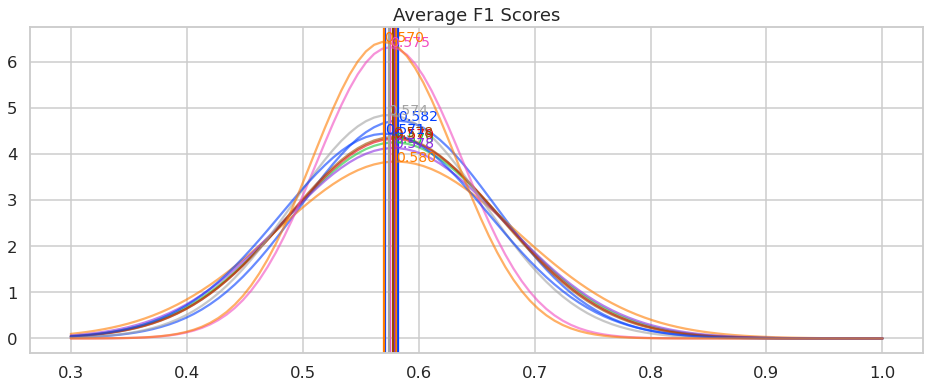

In [16]:
plot_some_tune_results(top_n_df, (0.3, 1.0))

In [17]:
%load_ext tensorboard
from tensorboard import notebook 
%tensorboard --logdir "~/ray_results/seg_facies"
notebook.display(height=1000)

Reusing TensorBoard on port 6007 (pid 59692), started 22:07:38 ago. (Use '!kill 59692' to kill it.)

Selecting TensorBoard with logdir ~/ray_results/seg_facies (started 22:07:38 ago; port 6007, pid 59692).


In [18]:
ray.shutdown()